In [87]:
import pandas as pd
import numpy as np

In [88]:
df = pd.read_pickle('data/SBAmodel.pickle')
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
df.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,1997-02-28,1997,84,4,2,0,0,1,0,0,1,NaN,1999-02-28,60000.0,$0.00,1,0.0,60000.0,48000.0


# Feature engenering

In [89]:
df['immo'] = np.where(df['Term'] >= 240, 1, 0)
df['NAICS_enc'] = df.NAICS.astype(object).str[0:1].astype(int)

v = df['BankState'].value_counts()
for idx,name in enumerate(v.index.tolist()):
    if v[idx] < 10000:
        #df.drop(df[df['BankState'] == name].index, inplace = True)
        df.loc[df['BankState'] == name, 'BankState'] = 'unknown'

df['BankState'].value_counts()

/var/folders/zp/c97k147160ddnklbfc2rk3hr0000gn/T/ipykernel_17602/1615965594.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if v[idx] < 10000:


BankState
unknown    166054
CA         118255
NC          79526
IL          66006
OH          58498
SD          51105
TX          48069
RI          45385
NY          39661
VA          29007
DE          24541
MN          19971
UT          19015
PA          17191
WI          15445
MO          14879
MA          13983
FL          13863
GA          13849
AL          12139
OR          11394
WA          10716
CO          10612
Name: count, dtype: int64

# Split

In [90]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['MIS_Status'])
y = df.MIS_Status

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.05,
    stratify=y,
    random_state=42
)

X_train.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,immo,NAICS_enc
475837,4584374002,BENEFIELD LEVENGER MCENDY& VER,SANTA ROSA,CA,95404,"CAPITAL ACCESS GROUP, INC.",CA,54,2001-06-18,2001,240,4,1,4,3,1,1,0,0,NaN,2001-09-14,208000.0,$0.00,0.0,208000.0,208000.0,1,5


## pipeline

In [105]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FunctionTransformer, make_pipeline
from feature_engine.selection import DropFeatures
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier

set_config(transform_output = "pandas")

drop_leaking = DropFeatures(features_to_drop=['ChgOffPrinGr', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross'])
drop = DropFeatures(features_to_drop=['BankState', 'LoanNr_ChkDgt', 'Name', 'City', 'Bank', 'State', 'NAICS'])#, 'NewExist'])
ohe = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')

transformers = ColumnTransformer(
    transformers = [
        ('date', FunctionTransformer(lambda x: x.astype(int)), ['ApprovalDate']),
        ('ohe', ohe, ['UrbanRural', 'NewExist', 'LowDoc', 'NAICS_enc', 'FranchiseCode']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

scaler = StandardScaler()
# estimator = XGBClassifier(n_estimators=5, max_depth=5)
estimator = RandomForestClassifier(max_depth=3)

feature_selection = make_pipeline(
    SelectFromModel(estimator=estimator)
)

pipe = make_pipeline(
            drop_leaking,
            drop,
            transformers,
            scaler,
            feature_selection,
            estimator)

pipe.fit(X_train, y_train)

Pipeline(steps=[('dropfeatures-1',
                 DropFeatures(features_to_drop=['ChgOffPrinGr', 'ChgOffDate',
                                                'DisbursementDate',
                                                'DisbursementGross',
                                                'BalanceGross'])),
                ('dropfeatures-2',
                 DropFeatures(features_to_drop=['BankState', 'LoanNr_ChkDgt',
                                                'Name', 'City', 'Bank', 'State',
                                                'NAICS'])),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date...
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['UrbanRural', 'NewExist',
                                                   'LowDoc', 'NAICS_enc',
                                                   'FranchiseCode'])],
                                   verbose_feature_names_out=False)),
                ('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('selectfrommodel',
                                  SelectFromModel(estimator=RandomForestClassifier(max_depth=3)))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=3))])

In [106]:
pipe.score(X_test, y_test)

0.8800240218866078

In [63]:
d = pipe[:-1].fit_transform(X_train, y_train)
display(d.head(1))

,ApprovalDate,BankState_AK,BankState_AL,BankState_AR,BankState_AZ,BankState_CA,BankState_CO,BankState_CT,BankState_DC,BankState_DE,BankState_FL,BankState_GA,BankState_HI,BankState_IA,BankState_ID,BankState_IL,BankState_IN,BankState_KS,BankState_KY,BankState_LA,BankState_MA,BankState_MD,BankState_ME,BankState_MI,BankState_MN,BankState_MO,BankState_MS,BankState_MT,BankState_NC,BankState_ND,BankState_NE,BankState_NH,BankState_NJ,BankState_NM,BankState_NV,BankState_NY,BankState_OH,BankState_OK,BankState_OR,BankState_PA,BankState_PR,BankState_RI,BankState_SC,BankState_SD,BankState_TN,BankState_TX,BankState_UT,BankState_VA,BankState_VT,BankState_WA,BankState_WI,BankState_WV,BankState_WY,UrbanRural_0,UrbanRural_1,UrbanRural_2,NewExist_2,LowDoc_1,NAICS_enc_0,NAICS_enc_1,NAICS_enc_2,NAICS_enc_3,NAICS_enc_4,NAICS_enc_5,NAICS_enc_6,NAICS_enc_7,NAICS_enc_8,NAICS_enc_9,FranchiseCode_1,Zip,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,GrAppv,SBA_Appv,immo
406471,-0.126061,-0.040022,-0.117061,-0.084303,-0.06667,-0.388947,-0.109414,-0.105768,-0.066688,-0.167561,-0.125118,-0.125012,-0.057828,-0.105643,-0.070621,-0.281467,-0.092437,-0.09974,-0.070007,-0.075347,-0.125816,-0.088927,-0.064473,-0.090741,-0.150921,-0.129767,-0.081708,-0.093806,-0.311433,-0.075824,-0.077516,-0.087423,-0.103098,-0.070268,14.355428,-0.214852,-0.263956,-0.090741,-0.113208,-0.139746,-0.013119,-0.230629,-0.091583,-0.245596,-0.079427,-0.237389,-0.146938,-0.182308,-0.073122,-0.109737,-0.132286,-0.047265,-0.049418,-0.749106,0.954235,-0.364263,-0.626557,-1.336218,-0.538258,-0.100629,-0.288902,-0.285935,-0.532399,-0.421199,3.680217,-0.317167,-0.296446,-0.01605,0.550246,0.688436,-0.193257,1.639759,0.008212,0.015158,-0.045519,-0.692629,1.403115,1.282795,2.216889


## Score

In [107]:
from sklearn.metrics import classification_report

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))


model = pipe.named_steps['randomforestclassifier']

              precision    recall  f1-score   support

           0       0.79      0.43      0.56      7878
           1       0.89      0.98      0.93     37081

    accuracy                           0.88     44959
   macro avg       0.84      0.70      0.74     44959
weighted avg       0.87      0.88      0.87     44959



# Matrice de confusion

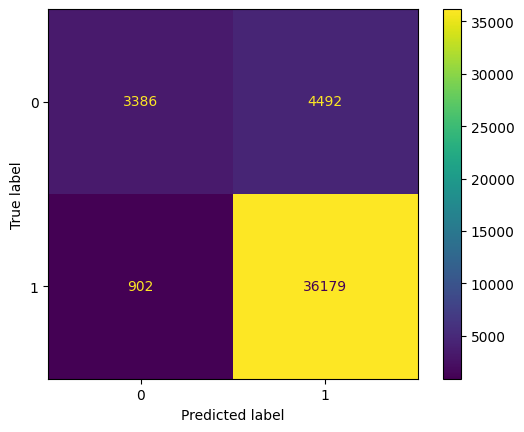

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cf_matrix).plot()

### Feature importance

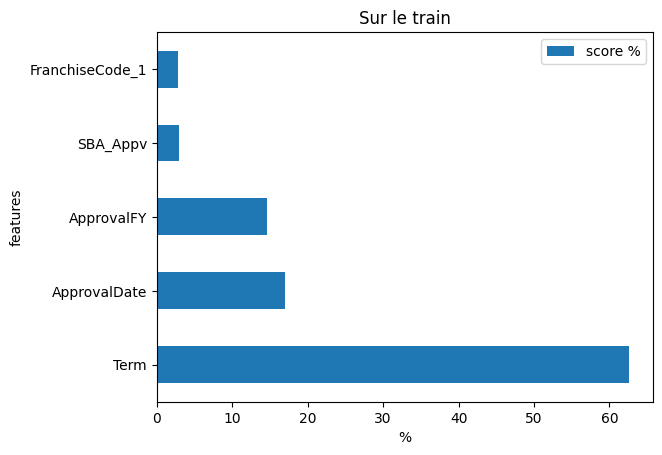

In [110]:
from utils import feature_importance
from matplotlib import pyplot as plt


f, X_train_transf = feature_importance(X_train, y_train, model, pipe)

f.loc[f.index < 11].plot.barh(y='score %', x='features')
plt.title('Sur le train')
plt.xlabel('%')
plt.legend()

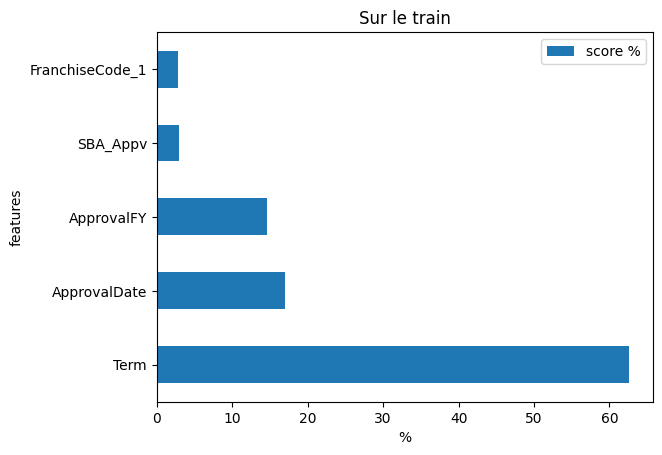

In [111]:
from matplotlib import pyplot as plt


f.loc[f.index < 11].plot.barh(y='score %', x='features')
plt.title('Sur le train')
plt.xlabel('%')
plt.legend()

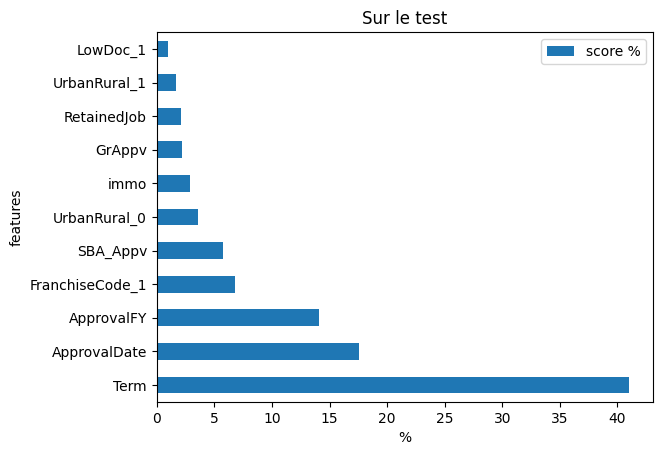

In [103]:
f, X_test_transf = feature_importance(X_test, y_test, model, pipe)

f.loc[f.index < 11].plot.barh(y='score %', x='features')
plt.title('Sur le test')
plt.xlabel('%')
plt.legend()

In [11]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = model,
    X = X_train_transf,
    y = y_train,
    train_sizes = np.linspace(0.01, 1, 10),
    cv = 3,
    scoring = 'f1_macro',
    n_jobs=-1
)

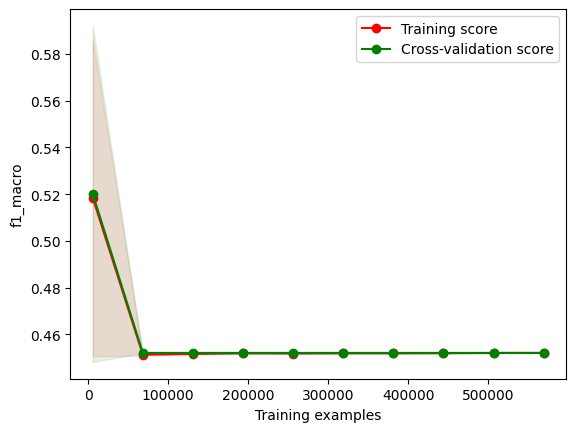

In [12]:
import matplotlib.pyplot as plt

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(validation_scores, axis=1)
test_std = np.std(validation_scores, axis=1)

# afficher les points
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

# relier les points
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.xlabel("Training examples")
plt.ylabel("f1_macro")

plt.legend()